In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import ta as ta                                                        # technical analysis library
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense,LSTM,Activation,Dropout,RepeatVector,TimeDistributed,Bidirectional
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.metrics import RootMeanSquaredError, MeanSquaredError, MeanAbsoluteError
from scipy.stats import mannwhitneyu


In [4]:
# I used Google Chrome whilst working in Google Colab so I was able to complete this step by recieving the authorisation code after logging into my gmail account.
# Users may need to also use Google Chrome to run this code and connect via the browser to your gmail when prompted.

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load the dataset

In [5]:
from google.colab import files
import io
uploaded = files.upload()

Saving dataset.csv to dataset.csv


In [6]:
df = pd.read_csv(io.BytesIO(uploaded['dataset.csv']), header=None)

In [7]:
#df = pd.read_csv('dataset.csv', header=None)

df.columns = ['Open Time', 'Open', 'High', 'Low', 'Close', 'Volume (ETH)', 'Close Time', 'Quote Asset Volume (USDT)', 
              'No. of trades', 'Buy Base Volume (ETH)', 'Buy Quote Volume (USDT)', 'Ignore']

# Preprocessing steps 
##### (Explained in the workbook titled 'Exploratory Data Analysis & Preprocessing)

In [8]:
df['Open Date'] = pd.to_datetime(df['Open Time'], unit='ms')

In [9]:
df['Close Date'] = pd.to_datetime(df['Close Time'], unit='ms')

In [10]:
df['Close Date'] = df['Close Date'].dt.normalize()

In [11]:
df.drop(['Open Time', 'Close Time'], axis=1, inplace=True)

In [12]:
df.drop(['Ignore', 'Volume (ETH)', 'No. of trades', 'Buy Base Volume (ETH)', 'Buy Quote Volume (USDT)', 'Open Date'], axis=1, inplace=True)

In [13]:
df.rename(columns = {'Quote Asset Volume (USDT)':'Volume'}, inplace = True)

In [14]:
df.set_index('Close Date', inplace=True)
df.head()

,Open,High,Low,Close,Volume
Close Date,,,,,
2017-08-17,301.13,312.18,298.00,302.00,2.154655e+06
2017-08-18,302.00,311.79,283.94,293.96,2.858947e+06
2017-08-19,293.31,299.90,278.00,290.91,6.200226e+05
2017-08-20,289.41,300.53,282.85,299.10,7.428479e+05
2017-08-21,299.10,346.52,294.60,323.29,1.689472e+06


In [15]:
columns = df.columns.tolist()
columns = columns[-1:] + columns[:-1]
df = df[columns]

In [16]:
df.head()

,Volume,Open,High,Low,Close
Close Date,,,,,
2017-08-17,2.154655e+06,301.13,312.18,298.00,302.00
2017-08-18,2.858947e+06,302.00,311.79,283.94,293.96
2017-08-19,6.200226e+05,293.31,299.90,278.00,290.91
2017-08-20,7.428479e+05,289.41,300.53,282.85,299.10
2017-08-21,1.689472e+06,299.10,346.52,294.60,323.29


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1412 entries, 2017-08-17 to 2021-06-28
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Volume  1412 non-null   float64
 1   Open    1412 non-null   float64
 2   High    1412 non-null   float64
 3   Low     1412 non-null   float64
 4   Close   1412 non-null   float64
dtypes: float64(5)
memory usage: 66.2 KB


# I will apply the Money Flow Index technical indicator on the close prices of the data to generate a new dataset which includes this new feature

In [18]:
mfi_indicator = ta.volume.MFIIndicator(high=df['High'], low=df['Low'], close=df['Close'], volume=df['Volume'], window=14)
df['Money Flow Index'] = mfi_indicator.money_flow_index()

In [19]:
columns2 = df.columns.tolist()
columns2 = columns2[-1:] + columns2[:-1]
df = df[columns2]
print(columns2)

['Money Flow Index', 'Volume', 'Open', 'High', 'Low', 'Close']


In [20]:
df # the new feature contains null values due to the indicator requiring initialisation using a few datapoints. I will drop these rows.

,Money Flow Index,Volume,Open,High,Low,Close
Close Date,,,,,,
2017-08-17,NaN,2.154655e+06,301.13,312.18,298.00,302.00
2017-08-18,NaN,2.858947e+06,302.00,311.79,283.94,293.96
2017-08-19,NaN,6.200226e+05,293.31,299.90,278.00,290.91
2017-08-20,NaN,7.428479e+05,289.41,300.53,282.85,299.10
2017-08-21,NaN,1.689472e+06,299.10,346.52,294.60,323.29
...,...,...,...,...,...,...
2021-06-24,33.856171,1.377800e+09,1967.95,2036.61,1884.79,1989.52
2021-06-25,34.092596,1.612557e+09,1989.53,2019.99,1791.22,1808.82
2021-06-26,35.110485,1.478551e+09,1808.97,1852.80,1717.32,1829.64


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1412 entries, 2017-08-17 to 2021-06-28
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Money Flow Index  1399 non-null   float64
 1   Volume            1412 non-null   float64
 2   Open              1412 non-null   float64
 3   High              1412 non-null   float64
 4   Low               1412 non-null   float64
 5   Close             1412 non-null   float64
dtypes: float64(6)
memory usage: 77.2 KB


In [22]:
df.dropna(inplace=True)

In [23]:
df.head()

,Money Flow Index,Volume,Open,High,Low,Close
Close Date,,,,,,
2017-08-30,77.379717,1.679526e+06,374.70,393.71,362.05,385.93
2017-08-31,79.222497,1.704441e+06,384.64,389.36,377.78,384.79
2017-09-01,89.498889,1.635228e+06,386.44,394.39,383.18,388.46
2017-09-02,80.780423,2.904008e+06,388.58,394.32,320.08,343.14
2017-09-03,74.809442,1.801703e+06,343.56,367.28,320.08,341.77


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1399 entries, 2017-08-30 to 2021-06-28
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Money Flow Index  1399 non-null   float64
 1   Volume            1399 non-null   float64
 2   Open              1399 non-null   float64
 3   High              1399 non-null   float64
 4   Low               1399 non-null   float64
 5   Close             1399 non-null   float64
dtypes: float64(6)
memory usage: 76.5 KB


# I need to repeat the same preprocessing steps as above on the new dataset to prepare it for machine learning

#### Split new dataset into training and testing datasets
#### 74.15% of the data will be used for training and the remaining 25.85% will be used as the test set (the same the original raw ETH dataset)

In [25]:
new_split = int(len(df)*0.7415)

new_training_set = df[:new_split]      # 17/8/2017 - 28/6/2020
new_test_set = df[new_split:]         # 29/6/2020 - 28/6/2021


In [26]:
print('New Training Set: ', new_training_set.shape, '\nNew Test Set: ', new_test_set.shape)

New Training Set:  (1037, 6) 
New Test Set:  (362, 6)


#### Split the data into X and y variables

In [27]:
new_X_training = (new_training_set.iloc[:, :]).values.reshape(new_training_set.shape[0],new_training_set.shape[1])
new_y_training = (new_training_set.iloc[:, -1]).values.reshape(new_training_set.shape[0],1)

print(new_X_training.shape, new_y_training.shape)

new_X_testing = (new_test_set.iloc[:, :]).values.reshape(new_test_set.shape[0],new_test_set.shape[1])
new_y_testing = (new_test_set.iloc[:, -1]).values.reshape(new_test_set.shape[0],1)

print(new_X_testing.shape, new_y_testing.shape)

(1037, 6) (1037, 1)
(362, 6) (362, 1)


#### Normalisation
#### The values need to be scaled to between 0 and 1 so I will use MinMaxScaler to do this
##### https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html




In [28]:
new_Xscaler = MinMaxScaler(feature_range=(0,1))
new_yscaler = MinMaxScaler(feature_range=(0,1))

new_X_train = new_Xscaler.fit_transform(new_X_training)
new_y_train = new_yscaler.fit_transform(new_y_training)

new_X_test = new_Xscaler.fit_transform(new_X_testing)
new_y_test = new_yscaler.fit_transform(new_y_testing)

#### Prepare data for multi-step LSTM
#### source code: https://pangkh98.medium.com/multi-step-multivariate-time-series-forecasting-using-lstm-92c6d22cd9c2

In [29]:
# stack the data horizontally

new_train_stacked = np.hstack((new_X_train, new_y_train))
print ("New Stacked Training Data Shape: " , new_train_stacked.shape)

new_test_stacked = np.hstack((new_X_test, new_y_test))
print ("New Stacked Test Data Shape: " , new_test_stacked.shape)

New Stacked Training Data Shape:  (1037, 7)
New Stacked Test Data Shape:  (362, 7)


In [30]:
# create sequences (n_steps_in = input timesteps, n_steps_out = output timesteps)

def create_sequences(sequences, n_steps_in, n_steps_out):
 X, y = [], []

 for i in range(len(sequences)):

  # find the end of this pattern
  end_ix = i + n_steps_in
  out_end_ix = end_ix + n_steps_out-1

  # check if we are beyond the dataset
  if out_end_ix > len(sequences):
   break

  # gather input and output parts of the pattern
  seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
  X.append(seq_x)
  y.append(seq_y)
 return np.array(X), np.array(y)

   

In [31]:
# choose a number of time steps 
n_steps_in, n_steps_out = 14, 7    

# run function
new_X_train, new_y_train = create_sequences(new_train_stacked, n_steps_in, n_steps_out)
print ("New X train sequences: " , new_X_train.shape, "new y train sequences" , new_y_train.shape)            

new_X_test, new_y_test = create_sequences(new_test_stacked, n_steps_in, n_steps_out)
print ("New X test sequences: " , new_X_test.shape, "New y test sequences" , new_y_test.shape)    

New X train sequences:  (1018, 14, 6) new y train sequences (1018, 7)
New X test sequences:  (343, 14, 6) New y test sequences (343, 7)


# **1. Model Building on CoLab for Multi-Step LSTM model (labelled in the code as Model A)**


#### I will now create an LSTM model with the same optimal parameters and architecture discovered from hypertuning. This model will be trained on the new dataset with additional technical analysis features.


In [32]:
new_n_features = new_X_train.shape[2]

rmse = RootMeanSquaredError()
mae = MeanAbsoluteError()

new_model_a = Sequential()
new_model_a.add(LSTM(units=80, activation='relu', return_sequences=True, input_shape=(n_steps_in, new_n_features)))
new_model_a.add(LSTM(units=80, activation='relu', return_sequences=True))
new_model_a.add(Dropout(0.3))
new_model_a.add(LSTM(units=80, activation='relu'))
new_model_a.add(Dropout(0.3))
new_model_a.add(Dense(n_steps_out))
new_model_a.compile(loss='mse' , optimizer=keras.optimizers.Adam(learning_rate= 0.001) , metrics=[rmse, mae])

In [33]:
new_model_a.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 14, 80)            27840     
_________________________________________________________________
lstm_1 (LSTM)                (None, 14, 80)            51520     
_________________________________________________________________
dropout (Dropout)            (None, 14, 80)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 80)                51520     
_________________________________________________________________
dropout_1 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense (Dense)                (None, 7)                 567       
Total params: 131,447
Trainable params: 131,447
Non-trainable params: 0
__________________________________________________

#### Train the model with the optimal parameters and test it on the test set 5 times to predict ETH close prices.
https://github.com/yanghaocsg/keras_lstm/wiki/chapter-7.1-Evaluating-LSTM-Models-Robustly


Training Number  0


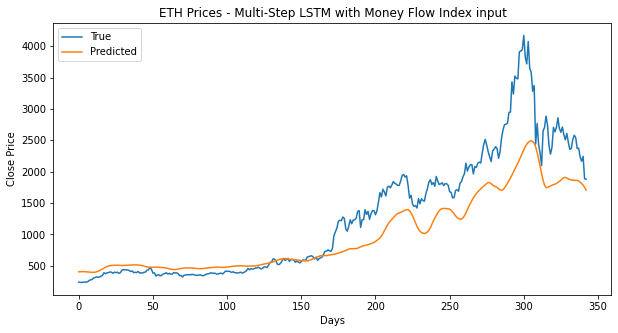


Testing Loss:  0.0176  ||  Testing RMSE:  0.133  ||  Testing MAE:  0.0911

Training Number  1


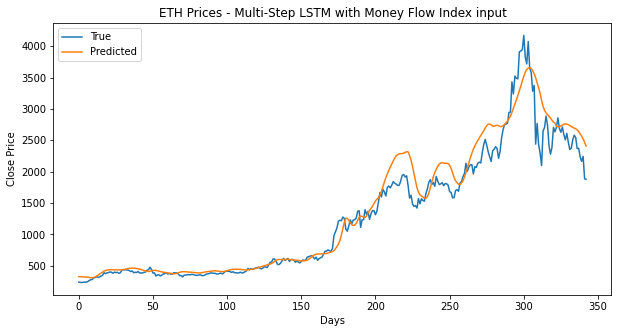


Testing Loss:  0.005  ||  Testing RMSE:  0.0707  ||  Testing MAE:  0.043

Training Number  2


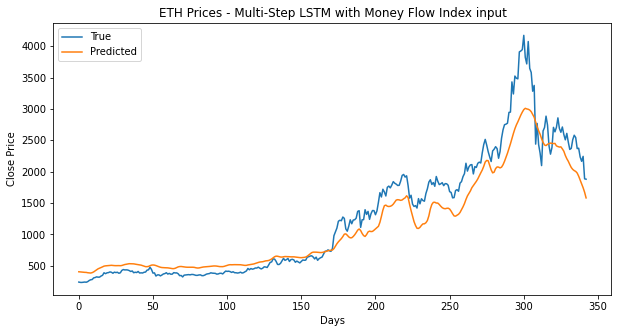


Testing Loss:  0.00739  ||  Testing RMSE:  0.086  ||  Testing MAE:  0.0616

Training Number  3


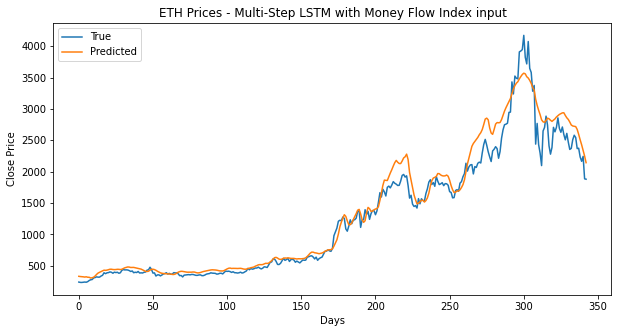


Testing Loss:  0.00329  ||  Testing RMSE:  0.0573  ||  Testing MAE:  0.0373

Training Number  4


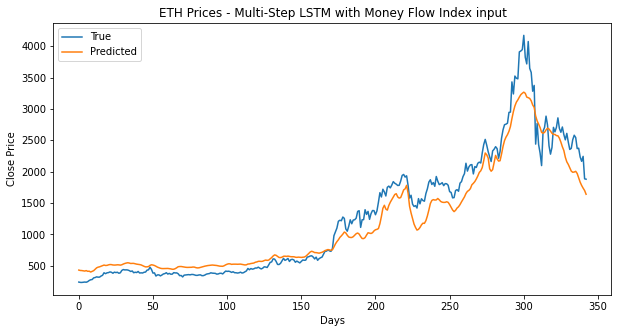


Testing Loss:  0.00598  ||  Testing RMSE:  0.0773  ||  Testing MAE:  0.0584

Multi-Step LSTM with Money Flow Index input -- 
Average Test Loss:  0.00786  ||  Average Test RMSE:  0.0848  ||  Average Test MAE:  0.0583


In [34]:
y_test_inv = new_yscaler.inverse_transform(new_y_test)

newlosslist_a = []
newrmselist_a = []
newmaelist_a = []

for i in range(5):

  # fit model
  print('\nTraining Number ', i)
  new_model_a.fit(new_X_train , new_y_train , epochs=61, shuffle=False, verbose = 0)    # Best epoch from optimisation code notebook for this model was 61

  # generate the test predictions and plot them against the true values

  test_pred_new_a = new_model_a.predict(new_X_test)
  test_pred_new_a = new_yscaler.inverse_transform(test_pred_new_a)

  plt.figure(figsize = (10, 5))
  plt.plot(y_test_inv[:,0], label = 'True')
  plt.plot(test_pred_new_a[:,0], label = 'Predicted')
  plt.legend()
  plt.title("ETH Prices - Multi-Step LSTM with Money Flow Index input")
  plt.xlabel("Days")
  plt.ylabel("Close Price")
  plt.show()

  # generate the scores

  test_loss_new_a, test_rmse_new_a, test_mae_new_a = new_model_a.evaluate(new_X_test, new_y_test, verbose = 0)

  print('\nTesting Loss: ', float('%.3g' % test_loss_new_a), ' ||  Testing RMSE: ', float('%.3g' % test_rmse_new_a), ' ||  Testing MAE: ', float('%.3g' % test_mae_new_a))

  newlosslist_a.append(test_loss_new_a)
  newrmselist_a.append(test_rmse_new_a)
  newmaelist_a.append(test_mae_new_a)

print('\nMulti-Step LSTM with Money Flow Index input -- \nAverage Test Loss: ', float('%.3g' % np.mean(newlosslist_a)), ' ||  Average Test RMSE: ', float('%.3g' % np.mean(newrmselist_a)), 
      ' ||  Average Test MAE: ', float('%.3g' % np.mean(newmaelist_a)))

# **2. Model Building on CoLab for Encoder-Decoder LSTM model (labelled in the code as Model B)**

#### I will now create an Encoder Decoder LSTM model with the same optimal parameters and architecture discovered from hypertuning. This model will be trained on the new dataset with additional technical analysis features.


In [35]:
new_model_b = Sequential()
new_model_b.add(LSTM(units=90, activation='relu', input_shape=(n_steps_in, new_n_features)))
new_model_b.add(RepeatVector(n_steps_out))
new_model_b.add(LSTM(units=90, activation='relu', return_sequences=True))
new_model_b.add(Dropout(0.3))
new_model_b.add(LSTM(units=90, activation='relu', return_sequences=True))
new_model_b.add(Dropout(0.3))
new_model_b.add(LSTM(units=90, activation='relu', return_sequences=True))
new_model_b.add(Dropout(0.3))
new_model_b.add(TimeDistributed(Dense(10, activation='relu')))
new_model_b.add(TimeDistributed(Dense(n_steps_out)))
new_model_b.compile(loss='mse' , optimizer=keras.optimizers.Adam(learning_rate = 0.001), metrics=[rmse, mae])

In [36]:
new_model_b.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 90)                34920     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 7, 90)             0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 7, 90)             65160     
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 90)             0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 7, 90)             65160     
_________________________________________________________________
dropout_3 (Dropout)          (None, 7, 90)             0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 7, 90)            

#### Train the model with the optimal parameters and test it 5 times to predict ETH close prices.


Training Number  0


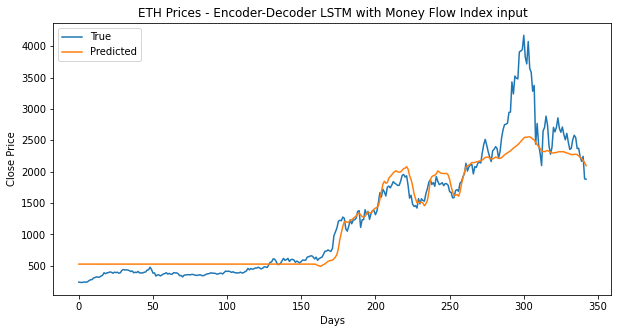


Testing Loss:  0.00488  ||  Testing RMSE:  0.0698  ||  Testing MAE:  0.0496

Training Number  1


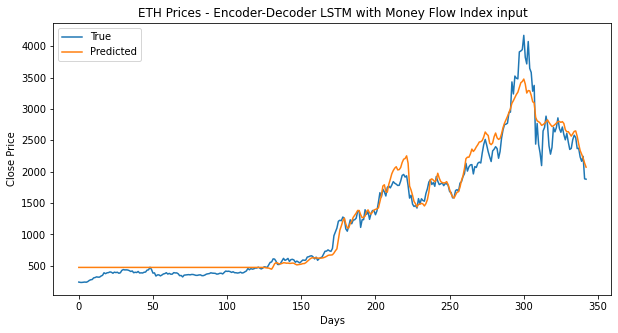


Testing Loss:  0.00272  ||  Testing RMSE:  0.0521  ||  Testing MAE:  0.035

Training Number  2


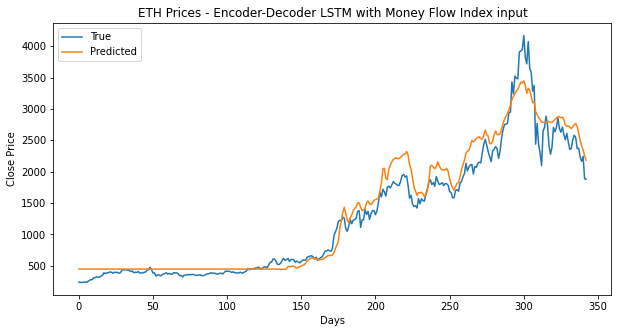


Testing Loss:  0.00415  ||  Testing RMSE:  0.0644  ||  Testing MAE:  0.0442

Training Number  3


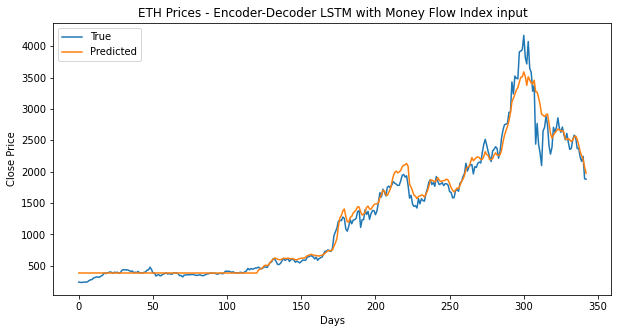


Testing Loss:  0.00277  ||  Testing RMSE:  0.0526  ||  Testing MAE:  0.0315

Training Number  4


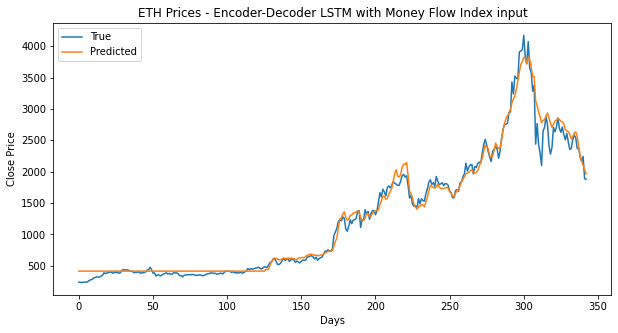


Testing Loss:  0.00309  ||  Testing RMSE:  0.0555  ||  Testing MAE:  0.0332

Encoder-Decoder LSTM with Money Flow Index input -- 
Average Test Loss:  0.00352  ||  Average Test RMSE:  0.0589  ||  Average Test MAE:  0.0387


In [37]:
newlosslist_b = []
newrmselist_b = []
newmaelist_b = []

for i in range(5):

  # fit model
  print('\nTraining Number ', i)

  # for encoder-decoder model, reshape output into [samples, timesteps, features]
  new_y_train_ed = new_y_train.reshape((new_y_train.shape[0], new_y_train.shape[1], 1))
  new_y_test_ed = new_y_test.reshape((new_y_test.shape[0], new_y_test.shape[1], 1))

  new_model_b.fit(new_X_train , new_y_train_ed , epochs=98, shuffle=False, verbose = 0)    # Best epoch from optimisation code notebook for this model was 98

  # generate the test predictions and plot them against the true values

  test_pred_new_b = new_model_b.predict(new_X_test)
  test_pred_new_b = test_pred_new_b.reshape((test_pred_new_b.shape[0], test_pred_new_b.shape[1]*test_pred_new_b.shape[2]))
  test_pred_new_b = new_yscaler.inverse_transform(test_pred_new_b)

  new_y_test_reshape = new_y_test_ed.reshape((new_y_test_ed.shape[0], new_y_test_ed.shape[1]*new_y_test_ed.shape[2]))
  new_y_test_reshape_inv = new_yscaler.inverse_transform(new_y_test_reshape)

  plt.figure(figsize = (10, 5))
  plt.plot(new_y_test_reshape_inv[:,0], label = 'True')
  plt.plot(test_pred_new_b[:,0], label = 'Predicted')
  plt.legend()
  plt.title("ETH Prices - Encoder-Decoder LSTM with Money Flow Index input")
  plt.xlabel("Days")
  plt.ylabel("Close Price")
  plt.show()

  # generate the scores

  test_loss_new_b, test_rmse_new_b, test_mae_new_b = new_model_b.evaluate(new_X_test, new_y_test_ed, verbose = 0)

  print('\nTesting Loss: ', float('%.3g' % test_loss_new_b), ' ||  Testing RMSE: ', float('%.3g' % test_rmse_new_b), ' ||  Testing MAE: ', float('%.3g' % test_mae_new_b))

  newlosslist_b.append(test_loss_new_b)
  newrmselist_b.append(test_rmse_new_b)
  newmaelist_b.append(test_mae_new_b)

print('\nEncoder-Decoder LSTM with Money Flow Index input -- \nAverage Test Loss: ', float('%.3g' % np.mean(newlosslist_b)), ' ||  Average Test RMSE: ', float('%.3g' % np.mean(newrmselist_b)), 
      ' ||  Average Test MAE: ', float('%.3g' % np.mean(newmaelist_b)))

# **3. Model Building on CoLab for Bidirectional LSTM model (labelled in the code as Model C)**

#### I will now create a Bidirectional LSTM model with the same optimal parameters and architecture discovered from hypertuning. This model will be trained on the new dataset with additional technical analysis features.


In [38]:
new_model_c = Sequential()
new_model_c.add(Bidirectional(LSTM(units=60, activation='relu', return_sequences=True), input_shape=(n_steps_in, new_n_features), merge_mode='sum'))
new_model_c.add(Bidirectional(LSTM(units=60, activation='relu', return_sequences=True), merge_mode='sum'))
new_model_c.add(Dropout(0.3))
new_model_c.add(Bidirectional(LSTM(units=60, activation='relu', return_sequences=True), merge_mode='sum'))
new_model_c.add(Dropout(0.3))
new_model_c.add(Bidirectional(LSTM(units=60, activation='relu'), merge_mode='sum'))
new_model_c.add(Dropout(0.3))
new_model_c.add(Dense(n_steps_out))
new_model_c.compile(loss='mse' , optimizer=keras.optimizers.Adam(learning_rate= 0.001) , metrics=[rmse, mae])


In [39]:
new_model_c.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 14, 60)            32160     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 14, 60)            58080     
_________________________________________________________________
dropout_5 (Dropout)          (None, 14, 60)            0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 14, 60)            58080     
_________________________________________________________________
dropout_6 (Dropout)          (None, 14, 60)            0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 60)                58080     
_________________________________________________________________
dropout_7 (Dropout)          (None, 60)               

#### Train the model with the optimal parameters and test it 5 times to predict ETH close prices.




Training Number  0


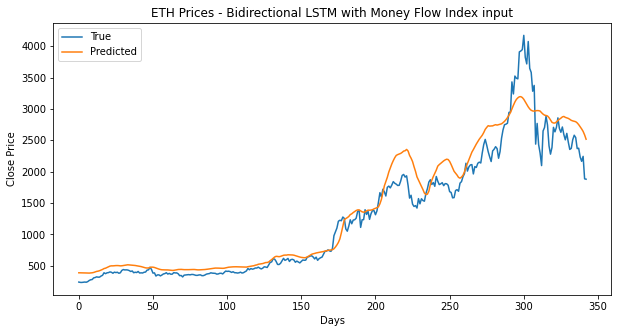


Testing Loss:  0.00505  ||  Testing RMSE:  0.0711  ||  Testing MAE:  0.0471

Training Number  1


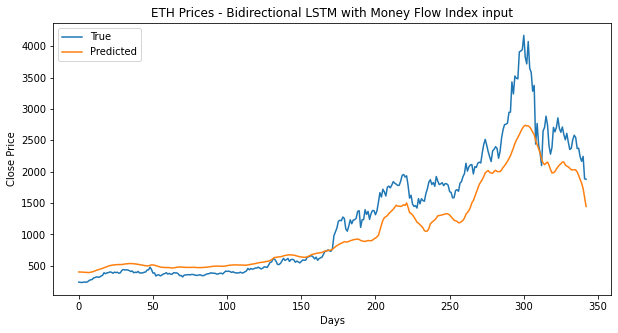


Testing Loss:  0.0123  ||  Testing RMSE:  0.111  ||  Testing MAE:  0.0788

Training Number  2


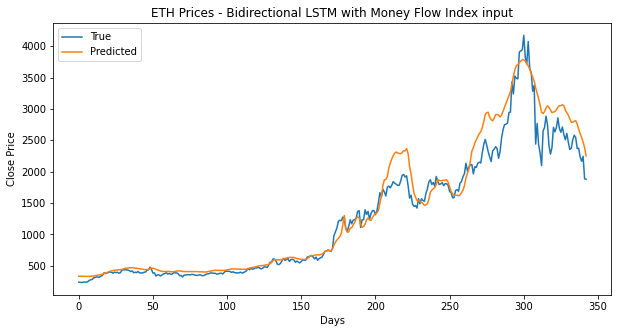


Testing Loss:  0.0043  ||  Testing RMSE:  0.0656  ||  Testing MAE:  0.0428

Training Number  3


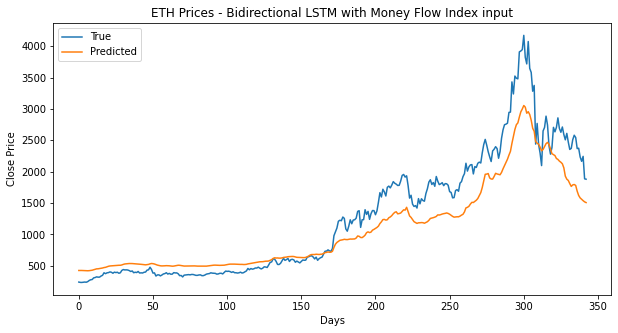


Testing Loss:  0.0101  ||  Testing RMSE:  0.1  ||  Testing MAE:  0.0752

Training Number  4


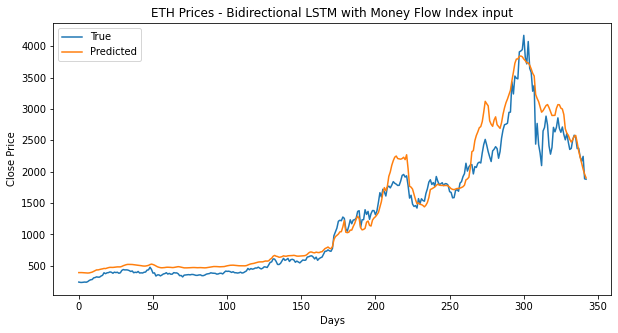


Testing Loss:  0.0042  ||  Testing RMSE:  0.0648  ||  Testing MAE:  0.0458

Bidirectional LSTM with Money Flow Index input -- 
Average Test Loss:  0.00718  ||  Average Test RMSE:  0.0825  ||  Average Test MAE:  0.058


In [40]:
newlosslist_c = []
newrmselist_c = []
newmaelist_c = []

for i in range(5):

  # fit model
  print('\nTraining Number ', i)
  new_model_c.fit(new_X_train , new_y_train , epochs=67, shuffle=False, verbose = 0)   # Best epoch from optimisation code notebook for this model was 67

  # generate the test predictions and plot them against the true values

  test_pred_new_c = new_model_c.predict(new_X_test)
  test_pred_new_c = new_yscaler.inverse_transform(test_pred_new_c)

  plt.figure(figsize = (10, 5))
  plt.plot(y_test_inv[:,0], label = 'True')
  plt.plot(test_pred_new_c[:,0], label = 'Predicted')
  plt.legend()
  plt.title("ETH Prices - Bidirectional LSTM with Money Flow Index input")
  plt.xlabel("Days")
  plt.ylabel("Close Price")
  plt.show()

  # generate the scores

  test_loss_new_c, test_rmse_new_c, test_mae_new_c = new_model_c.evaluate(new_X_test, new_y_test, verbose = 0)

  print('\nTesting Loss: ', float('%.3g' % test_loss_new_c), ' ||  Testing RMSE: ', float('%.3g' % test_rmse_new_c), ' ||  Testing MAE: ', float('%.3g' % test_mae_new_c))

  newlosslist_c.append(test_loss_new_c)
  newrmselist_c.append(test_rmse_new_c)
  newmaelist_c.append(test_mae_new_c)

print('\nBidirectional LSTM with Money Flow Index input -- \nAverage Test Loss: ', float('%.3g' % np.mean(newlosslist_c)), ' ||  Average Test RMSE: ', float('%.3g' % np.mean(newrmselist_c)), 
      ' ||  Average Test MAE: ', float('%.3g' % np.mean(newmaelist_c)))


# **Statistical comparison of results**
##### The dataset was determined to be non-parametric during the Exploratory Data Analysis stage. The models also have been trained on different training sets therefore I will be using a non-parametric, unpaired statistical hypothesis test to compare the performance of the baseline models with the models that have had additonal input.
##### I will be using the Mann-Whitney U Test from the SciPy Stats module on the RMSE scores for each of the models https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html

*   If p <= 0.05 then the null hypothesis is rejected. There is a statistically significant difference between the performances of the models.
*   If p > 0.05 then we accept the null hypothesis that there is no significant difference between the two performances and any potential differences are by chance.



In [41]:
# I need to read in the RMSE results from the baseline models.

# Baseline Multi-Step LSTM models (model A)
baseline_a = pd.read_csv('/content/drive/My Drive/Different Inputs/baselineScores_a.csv')
baseline_a = np.array(baseline_a)

# Baseline Encoder-Decoder LSTM models (model B)
baseline_b = pd.read_csv('/content/drive/My Drive/Different Inputs/baselineScores_b.csv')
baseline_b = np.array(baseline_b)

# Baseline Bidirectional LSTM models (model C)
baseline_c = pd.read_csv('/content/drive/My Drive/Different Inputs/baselineScores_c.csv')
baseline_c = np.array(baseline_c)

In [42]:
# Multi-Step LSTM models (model A)
stat1, p1 = mannwhitneyu(baseline_a, newrmselist_a)
print('Multi-Step LSTM Models: p-value is ', float('%.3g' % p1))

# Encoder-Decoder LSTM models (model B)
stat2, p2 = mannwhitneyu(baseline_b, newrmselist_b)
print('Encoder-Decoder LSTM Models: p-value is ', float('%.3g' % p2))

# Bidirectional LSTM models (model C)
stat3, p3 = mannwhitneyu(baseline_c, newrmselist_c)
print('Bidirectional LSTM Models: p-value is ', float('%.3g' % p3))

Multi-Step LSTM Models: p-value is  0.222
Encoder-Decoder LSTM Models: p-value is  0.31
Bidirectional LSTM Models: p-value is  0.0952
